In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from joblib import dump, load
from skimage import io, color
from skimage.transform import resize
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

from PIL import Image
%matplotlib inline

# Get the directory path
train_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train_ims"
test_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test_ims"

# List filenames in alphabetical order
train_filenames = sorted(os.listdir(train_directory_path))
test_filenames  = sorted(os.listdir(test_directory_path))

In [2]:
aug = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with 50% probability
    iaa.Flipud(0.5),  # Flip vertically with 50% probability
    iaa.Affine(rotate=(-10, 10)),  # Randomly rotate the image by up to 10 degrees
    iaa.GaussianBlur(sigma=(0.0, 0.5)),  # Apply Gaussian blur with a sigma between 0 and 0.5
])

In [3]:
x_train = []
x_test = []


train_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train.csv") #change path
test_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test.csv") #change path


for i in range(50000): #only checking first 1000 images
    image = io.imread(f"{train_directory_path}/{train_filenames[i]}")
    x_train.append(image)

    '''if i < 40000:
        x_train.append(image)
    else:
        x_test.append(image)
    '''
augmented_images = aug(images=x_train[10000:25000])

'''
for image in x_train[30000:40000]:
    augmented_images = augmentations(images=[image])
    augmented_x_train = np.concatenate((augmented_x_train, augmented_images), axis=0)
'''

for j in range(10000): #only checking first 500 images
    image = io.imread(f"{test_directory_path}/{test_filenames[j]}")
    x_test.append(image)

'''
y_train = np.concatenate((np.array(train_df["label"].to_numpy()[:40000]), np.array(train_df["label"].to_numpy()[30000:40000])))
y_test = np.array(train_df["label"].to_numpy()[-10000:])

x_train = np.concatenate((np.array(x_train), augmented_x_train))
x_test = np.array(x_test)
'''

x_train = np.array(x_train)
x_train = np.concatenate((x_train, augmented_images))

x_test = np.array(x_test)

y_train = np.array(train_df["label"].to_numpy())
y_train = np.concatenate((y_train, y_train[10000:25000]))

y_test = np.array(test_df["label"].to_numpy())

assert x_train.shape == (65000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

assert y_train.shape == (65000,)
assert y_test.shape == (10000,)


In [4]:
def get_sift_feature(im):
    gray_im = color.rgb2gray(im)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute((gray_im * 255).astype("uint8"), None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0) 

def get_hog_feature(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) / 255
    hog_features = hog(gray_im, orientations=6, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

    hsv_image = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    
    hist_features = []
    for channel in cv2.split(hsv_image):
        hist_features.append(cv2.calcHist([channel], [0], None, [8], [0, 256]))

    hist_features = np.concatenate(hist_features).flatten() / (image.shape[0] * image.shape[1])

    merged_features = np.concatenate((hog_features, hist_features))
    return(merged_features)


def sift_hog_combined_features(im):
    hog_features = get_hog_feature(im)
    sift_features = get_sift_feature(im)
    combined_features = np.concatenate((hog_features, sift_features))
    return combined_features

In [5]:
sift_hog_features_train = []
sift_hog_features_test = []

for image1 in x_train:
    sift_hog_features_train.append(sift_hog_combined_features(image1)) #checking for sift feature 

for image2 in x_test:
    sift_hog_features_test.append(sift_hog_combined_features(image2)) #checking for sift feature 

sift_hog_features_train = np.array(sift_hog_features_train)
sift_hog_features_test = np.array(sift_hog_features_test)

In [6]:
pca1 = PCA(0.9)
pca1.fit(sift_hog_features_train)
print(pca1.n_components_)
print(sift_hog_features_train.shape)


44
(65000, 368)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN

X_internal_train, X_internal_test, y_internal_train, y_internal_test = train_test_split(sift_hog_features_train, y_train, test_size=0.2, random_state=42)

pipe = Pipeline([
    ('StandardScaler', MinMaxScaler()),
    ('pca', PCA(0.9)),  
    ('knn', KNN(n_neighbors=10))
])


pipe.fit(X_internal_train, y_internal_train)

Pipeline(steps=[('StandardScaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.9)),
                ('knn', KNeighborsClassifier(n_neighbors=10))])

In [9]:
print(X_internal_train.shape)
print(X_internal_test.shape)
print(y_internal_train.shape)
print(y_train.shape)


(52000, 368)
(13000, 368)
(52000,)
(65000,)


In [10]:
#get accuracy
from sklearn.metrics import accuracy_score

y_pred = pipe.predict(X_internal_test)
accuracy = accuracy_score(y_internal_test, y_pred)
print(accuracy)

0.5117692307692308


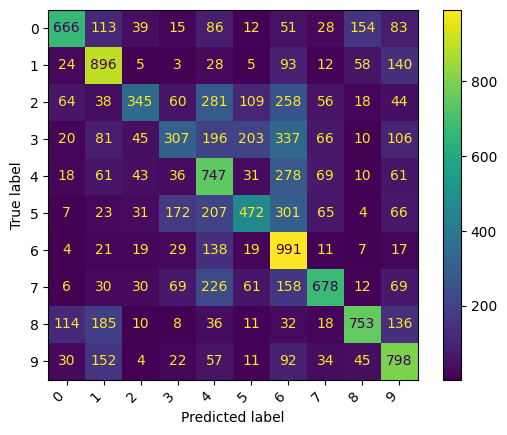

In [11]:
color = 'white'
cm = confusion_matrix(y_internal_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
y_pred_final = pipe.predict(sift_hog_features_test)